# Brownian Bridge with inversion method for option pricing.

To construct a Brownian bridge for option pricing, we first need to decide the number of simulations $N$ we wish to use and the number of discretisation nodes/steps, $s$, we would like to have. Next we generate $ N $ points from $ s $-dimensional uniformly distributed modulo one sequence $ (\boldsymbol{x}_n)_{n \in \mathbb{N}} $.  

To start the construction of Brownian bridge, consider one of the points in the $N$ samples generated, say, 
$ \boldsymbol{x}_0 = (x_1 , \dots , x_s) $
Next we apply the inverse c.d.f function of the Gaussian distribution (also known as point percentile function in NumPy) to the vector component-wise, 
$$ \Phi^{-1}(\boldsymbol{x}_0) = (\Phi^{-1}(x_1 ), \dots, \Phi^{-1}(x_s)) = (Z_1 , \dots, Z_s)$$ 
Then we define $ W_0 = 0 $ and $ W_T = \sqrt{T} Z_1 $. From here we can construct 
$$ W_{\frac{T}{2}} = \frac{1}{2}(W_0 + W_T)   + \sqrt{\frac{T}{4}} Z_2  $$
and with $ W_0 , W_{\frac{T}{2}}, W_T $ we can compute 
$$ W_{\frac{T}{4}} = \frac{1}{2} (W_0 + W_{\frac{T}{2}}) + \sqrt{\frac{T}{8}} Z_3 $$ 
$$ W_{\frac{3T}{4}} = \frac{1}{2} (W_{\frac{T}{2}} + W_T) + \sqrt{\frac{T}{8}} Z_4 $$
and the procedure continued recursively until all Brownian values
are defined. 

Upon completion we get a Brownian paths $ W_{t_1 } , W_{t_2 } , \dots,  W_{t_s} $ where $ t_1 < t_2 < \cdots < t_s $, this will be the Brownian bridge constructed by the point $\boldsymbol{x}_0$. Repeat the procedure above for the other $N-1$ points.

## Importing dependencies

In [1]:
from scipy.stats import qmc
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt 

## Brownian bridge constructon using Sobol' sequence

In [2]:
def BB_Sobol(vis = True, *, time, samples, steps):
    from scipy.stats import qmc
    from scipy.stats import norm
    import numpy as np
    import matplotlib.pyplot as plt 

    if np.log2(samples) != int(np.log2(samples)) or np.log2(steps) != int(np.log2(steps)):
        raise 'Samples or steps are not a power of 2'
    
    T = time
    disc = steps  # discretisation steps
    n_sims = samples # number of simulations

    disc_log2 = round(np.log2(disc)) # log 2 discretisation steps 
    n_sims_log2 = round(np.log2(n_sims)) # log 2 number of simulations 

    qmc.Sobol.reset
    S = qmc.Sobol(d = disc , scramble = True) 
    sobol = S.random_base2(n_sims_log2) # sampling from the Sobol' sequence, each row is a Sobol' point
    invnorm_sobol = norm.ppf(sobol)
    Wt = np.zeros([1, disc + 1]) # placeholder
    times = np.linspace(0, T, disc + 1) 

    for i in range(n_sims):
        sobol_ls = invnorm_sobol[i,:]
        WT = np.sqrt(T) * sobol_ls[0]
        ls = [(0,0), (T, WT)]
        n = 1 
        while n <= disc_log2 : 
            for i, j in enumerate(ls[:-1]):
                ls.append((0.5 * (j[0] + ls[i+1][0]), 0.5 * (j[1] + ls[i+1][1]) + np.sqrt(T / 2 ** (n + 1)) * sobol_ls[n]))

            n += 1
            ls = sorted(ls) 
        
        ls_arr = np.array(ls)
        Wt = np.vstack((Wt, ls_arr[:, 1]))
    
    Wt = Wt.T[:, 1:] # to not include the placeholder
    if vis:
        plt.plot(times, Wt)
        plt.xlabel('Time $T$')
        plt.ylabel('Brownian bridge paths')
        plt.title('{} Brownian bridge paths by Sobol\' Sequence'.format(samples))
        plt.show()
        return times, Wt
    else:
        return times, Wt

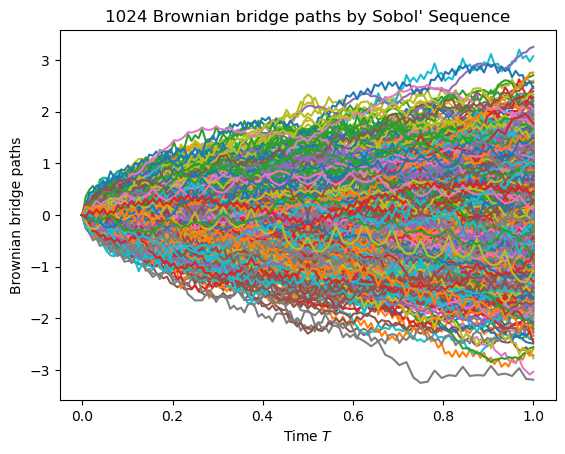

In [3]:
T = 1
sims = 2 ** 10
disc = 2 ** 7
times, Wt = BB_Sobol(time = T, samples = sims, steps = disc)

## Using Brownian bridge constructed by Sobol' sequence to approximate the arbitrage-free option pricing. 

In [4]:
# construct a geometric Brownian motion using Brownian bridge
def GBB_Sobol(vis = True, *, S0, time, steps, samples, vol, rfr):
    times, Bt = BB_Sobol(vis = False, time = time, steps = steps, samples = samples)
    times_d = np.tile(times, (samples,1)).T 
    St = S0 * np.exp((rfr - vol**2 /2)* times_d + vol * Bt)
    if vis:
        plt.plot(times, St)
        plt.xlabel('Time $T$')
        plt.ylabel('Stock price $S_T$')
        plt.title('{} Brownian bridge simulations by Sobol\' sequence'.format(samples))
        plt.show()
        return times, St
    else: 
        return times, St


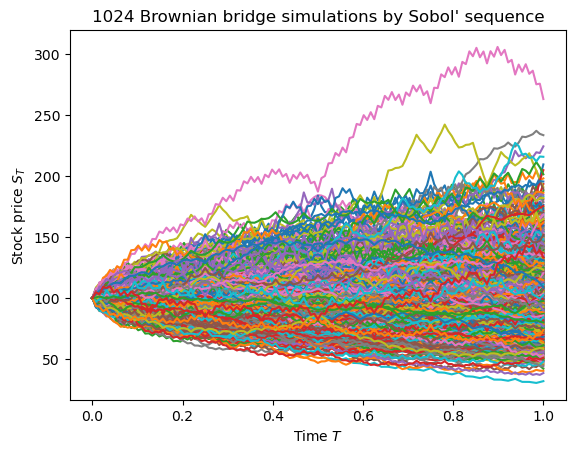

In [5]:
S0 = 100 # value of underlying asset at t = 0
r = 0 # risk-free rate
sigma = 0.3 # volitility 
K = 95

times, St = GBB_Sobol(time = T, samples = sims, steps = disc, S0 = S0, rfr = r, vol = sigma)

In [6]:
St1 = St[-1]
St1 = St1 - K 
C0_MC1 = St1[St1 > 0].sum() / St.shape[1] 
C0_MC1

14.293584386088472

In [7]:
def BS_option_call(*, maturity, S0, rfr, strike, time = 0, vol):
    import numpy as np 
    from scipy.stats import norm

    if time > strike:
        raise 'Time parameter is more than maturity parameter'
    
    d1 = (np.log(S0 / strike)  + (rfr + vol**2 /2) * (maturity - time)) / (vol * np.sqrt(maturity - time))
    d2 = (np.log(S0 / strike)  + (rfr - vol**2 /2) * (maturity - time)) / (vol * np.sqrt(maturity - time))
    return S0 * norm.cdf(d1) - np.exp(- rfr * (maturity - time)) * strike * norm.cdf(d2)

In [8]:
C0_BS1 = BS_option_call(maturity = T, S0 = S0, rfr = r, strike = K, vol = sigma)
C0_BS1

14.293649102263295

In [9]:
error = (np.abs(C0_MC1 - C0_BS1) / C0_BS1) * 100
print('Monte Carlo simulation option pricing (Sobol\'): ', C0_MC1)
print('Analytical Black-Scholes option pricing: ', C0_BS1)  
print('Percentage error: ', error, '%')

Monte Carlo simulation option pricing (Sobol'):  14.293584386088472
Analytical Black-Scholes option pricing:  14.293649102263295
Percentage error:  0.00045276174306233463 %


An amazing result using only 1024 samples as compared to 10,000 samples of the standard Monte Carlo method, where had a 1.351623675721982 % error (from Week 3 & 4 simulations).

# Halton sequence Brownian bridge

In [10]:
import sys
sys.path.append(r'/Users/cm/Documents/Python')
from Functions.qmc import *

In [11]:
def Halton_seq(bases, n):
    """
    Input: bases (iterable) and n is the number of points to generate
    Output: Return an array of Halton sequence (each row is a point in Halton sequence)
    """
    ls = []
    for x in bases:
        ls.append(vdc_seq(x, n))
    
    ls = np.array(ls).T
    return ls 

## Defining the Brownian bridge constructed by Halton sequence. 

In [12]:
# the Brownian bridge function using Halton sequence
# you can use this function by importing my qmc package
def BB_Halton(vis = True, *, time, samples, steps):
    from scipy.stats import norm
    import numpy as np
    import matplotlib.pyplot as plt 

    if np.log2(steps) != int(np.log2(steps)):
        raise 'Samples or steps are not a power of 2'
    
    T = time
    disc = steps  # discretisation steps
    n_sims = samples + 1 # number of simulations

    disc_log2 = round(np.log2(disc)) # log 2 discretisation steps 

    halton = Halton_seq(prime(disc), n_sims)
    invnorm_halton = norm.ppf(halton)
    Wt = np.zeros([1, disc + 1]) # placeholder
    times = np.linspace(0, T, disc + 1) 

    for i in range(n_sims):
        halton_ls = invnorm_halton[i,:]
        WT = np.sqrt(T) * halton_ls[0]
        ls = [(0,0), (T, WT)]
        n = 1 
        while n <= disc_log2 : 
            for i, j in enumerate(ls[:-1]):
                ls.append((0.5 * (j[0] + ls[i+1][0]), 0.5 * (j[1] + ls[i+1][1]) + np.sqrt(T / 2 ** (n + 1)) * halton_ls[n]))

            n += 1
            ls = sorted(ls) 
        
        ls_arr = np.array(ls)
        Wt = np.vstack((Wt, ls_arr[:, 1]))
    
    Wt = Wt.T[:, 2:] # to not include the placeholder
    if vis:
        plt.plot(times, Wt)
        plt.xlabel('Time $T$')
        plt.ylabel('Brownian bridge paths')
        plt.title('{} Brownian bridge paths by Halton Sequence'.format(samples))
        plt.show()
        return times, Wt
    else:
        return times, Wt

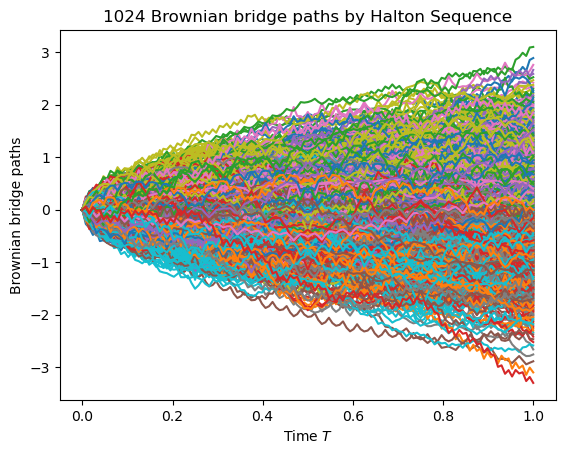

In [13]:
times, Wt = BB_Halton(time = T, steps = disc, samples = sims)

## Defining the Geometric Brownian motion constructed by Halton sequence Brownian bridge paths

In [14]:
# the Geometric Brownian motion function using Brownian bridge from Halton sequence
# you can use this function by importing my qmc package
def GBB_Halton(vis = True, *, S0, time, steps, samples, vol, rfr):
    times, Bt = BB_Halton(vis = False, time = time, steps = steps, samples = samples)
    times_d = np.tile(times, (samples,1)).T 
    St = S0 * np.exp((rfr - vol**2 /2)* times_d + vol * Bt)
    if vis:
        plt.plot(times, St)
        plt.xlabel('Time $T$')
        plt.ylabel('Stock price $S_T$')
        plt.title('{} Brownian bridge simulations by Halton sequence'.format(samples))
        plt.show()
        return times, St
    else: 
        return times, St


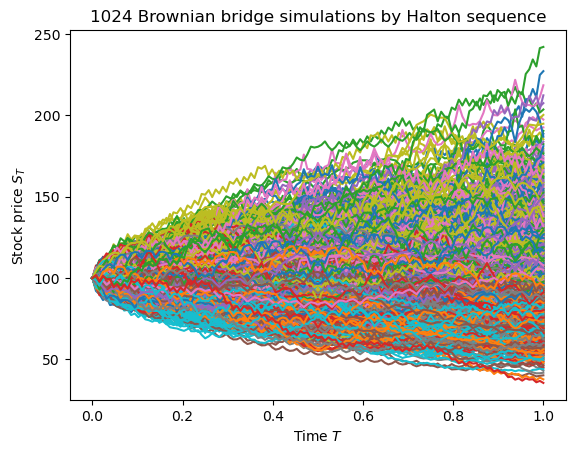

In [15]:
times, St = GBB_Halton(S0 = S0, time = T, steps = disc, samples = sims, vol = sigma, rfr = r)

In [16]:
St2 = St[-1] - K 
C0_MC2 = np.exp(-r * T) * St2[St2 > 0].sum() / St.shape[1] 
C0_MC2

14.20227210652681

In [17]:
error = (np.abs(C0_MC2 - C0_BS1) / C0_BS1) * 100
print('Monte Carlo simulation option pricing (Halton): ', C0_MC2)
print('Analytical Black-Scholes option pricing: ', C0_BS1)  
print('Percentage error: ', error, '%')


Monte Carlo simulation option pricing (Halton):  14.20227210652681
Analytical Black-Scholes option pricing:  14.293649102263295
Percentage error:  0.6392838881291463 %


## Performance comparison

In [18]:
# computing standard error 
St1[St1 <= 0 ] = 0
SE1 = St1.std(ddof = 1) / np.sqrt(sims) 

St2[St2 <= 0 ] = 0 
SE2 = St2.std(ddof = 1) / np.sqrt(sims) 


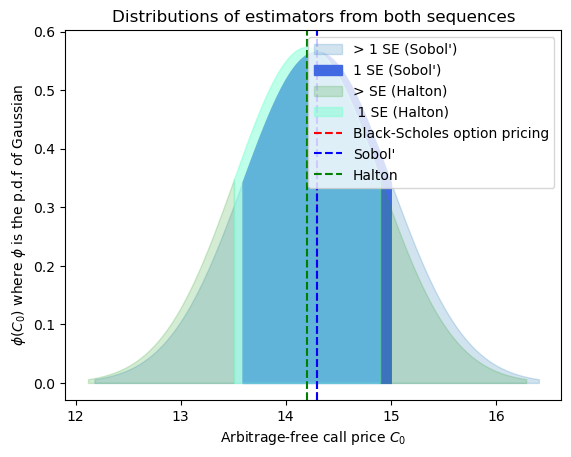

In [21]:

x1 = np.linspace(C0_MC1 - 3 * SE1, C0_MC1 - 1 * SE1, 100)
X1 = np.linspace(C0_MC2 - 3 * SE2, C0_MC2 - 1 * SE2, 100)
x2 = np.linspace(C0_MC1 - 1 * SE1, C0_MC1 + 1 * SE1, 100)
X2 = np.linspace(C0_MC2 - 1 * SE2, C0_MC2 + 1 * SE2, 100)
x3 = np.linspace(C0_MC1 + 1 * SE1, C0_MC1 + 3 * SE1, 100)
X3 = np.linspace(C0_MC2 + 1 * SE2, C0_MC2 + 3 * SE2, 100)

y1 = norm.pdf(x1, C0_MC1, SE1)
Y1 = norm.pdf(X1, C0_MC2, SE2)
y2 = norm.pdf(x2, C0_MC1, SE1)
Y2 = norm.pdf(X2, C0_MC2, SE2)
y3 = norm.pdf(x3, C0_MC1, SE1)
Y3 = norm.pdf(X3, C0_MC2, SE2) 

plt.fill_between(x1, y1, color = 'tab:blue', label = '> 1 SE (Sobol\')', alpha = 0.2)
plt.fill_between(x2, y2, color = 'royalblue', alpha = 1, label = '1 SE (Sobol\') ')
plt.fill_between(x3, y3, color = 'tab:blue', alpha = 0.2)

plt.fill_between(X1, Y1, color = 'tab:green', label = '> SE (Halton)', alpha = 0.2)
plt.fill_between(X2, Y2, color = 'aquamarine', label = ' 1 SE (Halton)', alpha = 0.5)
plt.fill_between(X3, Y3, color = 'tab:green', alpha = 0.2)

plt.axvline(x = C0_BS1, color = 'r', linestyle = 'dashed', label = 'Black-Scholes option pricing')
plt.axvline(x = C0_MC1, color = 'blue', linestyle = 'dashed', label = 'Sobol\'')
plt.axvline(x = C0_MC2, color = 'green', linestyle = 'dashed', label = 'Halton')

plt.xlabel('Arbitrage-free call price $C_0$')
plt.ylabel('$\phi(C_0)$ where $\phi$ is the p.d.f of Gaussian')
plt.title('Distributions of estimators from both sequences')
plt.legend()
plt.show()

Both are really good estimator, but Sobol' sequence is much better in this case. In this case, the blue line is on-top of the red line. 